In [1]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
%matplotlib inline

/home/carlosmiguelpatino/Software/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/carlosmiguelpatino/Software/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
data1 = pd.read_csv("./data/pulse_K1=-4500.csv")
data1 = data1[[' Oxs_TimeDriver::Simulation time (s)', ' Oxs_TimeDriver::mx', ' Oxs_TimeDriver::my', ' Oxs_TimeDriver::mz']]
data1.columns = ['Time', 'mx', 'my', 'mz']

In [8]:
data1.dtypes

Time    float64
mx      float64
my      float64
mz      float64
dtype: object

In [12]:
data1['Time'] = data1['Time'].str.strip()
data1['mz'] = data1['mz'].str.strip()
data1['Time'] = pd.to_numeric(data1['Time'], errors='coerce')
data1['mz'] = pd.to_numeric(data1['mz'], errors='coerce')
data1 = data1.dropna()

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [18]:
data1.dtypes[0]

dtype('float64')

In [9]:
decayind = signal.find_peaks_cwt(data1['mz'], np.arange(1,80))
decay = []
x_decay = []
for index in decayind:
    x_decay.append(data1['Time'][index])
    decay.append(data1['mz'][index])

(0, 1e-10)

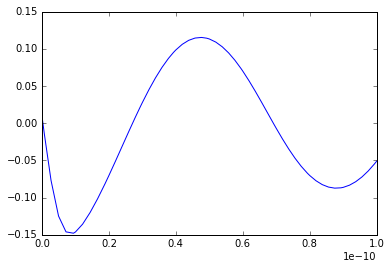

In [15]:
#plt.plot(x_decay, decay, c='r')
plt.plot(data1['Time'], data1['mz'])
plt.xlim(0,0.1e-9)

In [16]:
def exponential(x, a, b):
    return a * np.exp(-b * x)
popt, pcov = curve_fit(exponential, x_decay, decay)

The decay rate of mz is 1.93e+09


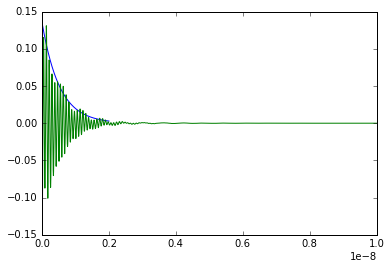

In [17]:
x = np.linspace(0, 2e-9, 1000)
y = exponential(np.array(x), *popt)
plt.plot(x, y)
plt.plot(data1['Time'], data1['mz'])
print('The decay rate of mz is {0:.3g}'.format(popt[1]))
decay_rates = []
decay_rates.append(popt[1])

In [18]:
dt = data1['Time'][1] - data1['Time'][0]
n = len(data1['mz']) 
mz_fft = fft(data1['mz'])
freq = fftfreq(n, dt)

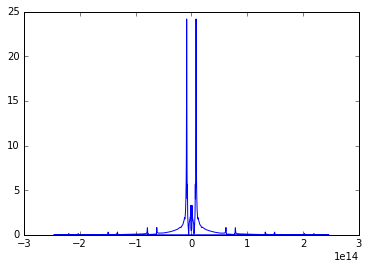

In [19]:
plt.plot(freq, abs(mz_fft))

In [20]:
max_freq = freq[mz_fft.argmax()]
print('The dominating frequency is {0:.3g} Hz'.format(max_freq))

The dominating frequency is 9.01e+12 Hz


In [27]:
peakind = signal.find_peaks_cwt(abs(mz_fft), np.arange(1,200))
peaks = []
x_peaks = []
for index in peakind:
    x_peaks.append(freq[index])
    peaks.append(abs(mz_fft[index]))
    
    
    

(0, 100000000000000.0)

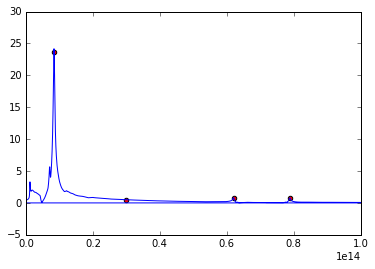

In [29]:
plt.scatter(x_peaks, peaks, c='r')
plt.plot(freq, abs(mz_fft))
plt.xlim(0, 1e14)